In [1]:
# !conda install -q -y ffmpeg

In [2]:
!wget https://dl3.pushbulletusercontent.com/VvNdOmD3SRsIGnP8lCniQf3BJzX7kgRL/neighborhoods.zip
!unzip -q neighborhoods.zip
!rm -rf __MACOSX/
!rm neighborhoods.zip

--2023-05-12 19:29:57--  https://dl3.pushbulletusercontent.com/VvNdOmD3SRsIGnP8lCniQf3BJzX7kgRL/neighborhoods.zip
Resolving dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)... 35.208.62.122
Connecting to dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)|35.208.62.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17123 (17K) [application/zip]
Saving to: ‘neighborhoods.zip’

neighborhoods.zip   100%[===================>]  16.72K  --.-KB/s    in 0.01s   

2023-05-12 19:29:57 (1.58 MB/s) - ‘neighborhoods.zip’ saved [17123/17123]



In [3]:
rule = [[(0, 1, 0), (3, 3, 1), (6, 6, 1), (4, 8, 0)]] # GoL
blocksize = 3
threshold = 0.06
width = 198
height = 198
steps = 9

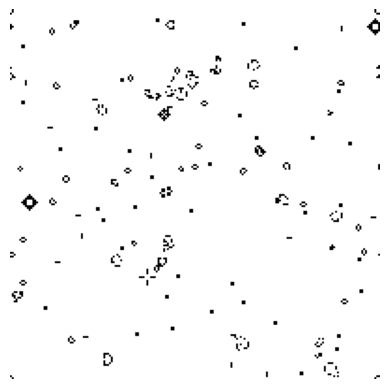

In [4]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from collections import Counter

############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############
def blockshaped(arr, nrows, ncols):
    
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


def FrequencyHistogramCoarseGraining(array_3d):
    time_steps,width,height = array_3d.shape
    # Let us split NxN array to smaller 2x2 blcks
    super_cells_list_volumetric =  []
    new_board_volumetric_supercells_list = []
    threshold1 = threshold
    # what are the lower limits of thresh and upper limits of thresh?
    # threshold2 = 0.06 # For multi state MNCA
    
    # given block shape of 2,2 says that we have a chunk of 2x2 that partitions complete w,h

    for grid_2d in array_3d:
      blocked_grid_2d = blockshaped(grid_2d,blocksize,blocksize)
      for each_sub_array in blocked_grid_2d:
        super_cells_list_volumetric.append(list(each_sub_array.flatten()))
    test_array=np.array(super_cells_list_volumetric)
    print(test_array.shape)
    for i in range(len(super_cells_list_volumetric)):
      count = 0
      for j in range(len(super_cells_list_volumetric)):
        if(super_cells_list_volumetric[i]==super_cells_list_volumetric[j]):
          count = count+1 # count is number of blocks matching in the same grid (ref literature)
      new_board_volumetric_supercells_list.append(count/len(super_cells_list_volumetric))

    a = super_cells_list_volumetric
    # calculate the total number of nested lists in the parent list
    total = len(a)

    # count the frequency of each unique nested list in the parent list
    freq = Counter(map(tuple, a))

    # calculate the probability of each unique nested list
    prob = {k: v / total for k, v in freq.items()}

    # create a histogram plot of the probabilities
    plt.bar(range(len(prob)), list(prob.values()))
    plt.xticks(range(len(prob)), [int(''.join(map(str, k)), 2) for k in prob.keys()])
    plt.xlabel('Decimal Values of the binary values in block')
    plt.ylabel('Probability of the occurence')
    plt.title('Probability of occurence of supercells vs (Decimal Values)')

    # set y-axis tick locations and labels
    plt.yticks([i/20 for i in range(21)], [f'{i/20:.2f}' for i in range(21)])

    plt.show()

    for k in range(len(new_board_volumetric_supercells_list)):
      if(new_board_volumetric_supercells_list[k] < threshold1):
        new_board_volumetric_supercells_list[k]=1
      else:
        new_board_volumetric_supercells_list[k]=0
            
    modified_board = np.array(new_board_volumetric_supercells_list)
    shape = int(np.sqrt(len(new_board_volumetric_supercells_list)/time_steps))
    # print(shape)
    modified_board_return = modified_board.reshape(time_steps,shape,shape)
    return modified_board_return
############# FHCG SECTION ##############    
############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############





def init_board(width, height, init_state):
    if init_state == "single cell in center":
        board = np.zeros((height, width), dtype=np.int)
        board[height//2, width//2] = 1
    elif init_state == "random cells with some probability":
        p = 0.080 # probability of a cell being alive
        board = np.random.choice([0, 1], size=(height, width), p=[1-p, p])
    elif init_state == "random cells with 2 different states":
        p1 = 0.250 # probability of a cell being state 1
        board = np.random.choice([0, 1, 2], size=(height, width), p=[1-p1, p1/2, p1/2])
    else:
        raise ValueError("Invalid initial state")
    return board

volume_board_data = []
def update(frame, img, board, neighborhoods, range_of_neighborhood_sums):
    new_board = np.zeros_like(board, dtype=int)
    height, width = board.shape
    for i in range(height):
        for j in range(width):
            next_state = board[i, j]
            for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
                cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                     for ni, nj in neighborhood]
                
                # # use this for sum
                neighborhood_sum = sum(cell_neighborhood)
                
                # use this for average
                # neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
                for lower, upper, new_next_state in range_of_neighborhood_sum:
                    if lower <= neighborhood_sum <= upper:
                        next_state = new_next_state
            new_board[i, j] = next_state
    board[:] = new_board[:]
    # board = FrequencyHistogramCoarseGraining(board) # Adding coarse grained
    import copy
    volume_board_data.append(copy.deepcopy(board)) # Collecting boaards in a list for coarse grianing
    img.set_data(board)
    return img,

def run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums):
    board = init_board(width, height, init_state)
    fig, ax = plt.subplots()
    plt.axis('off')
    img = ax.imshow(board, cmap='binary')
    ani = animation.FuncAnimation(fig, update, frames=steps, fargs=(img, board, neighborhoods, range_of_neighborhood_sums), repeat=False)
    ani.save(filename, writer='pillow')
    # ani.save(filename, writer='ffmpeg', codec='h264')



def extract_neighborhood_from_file(file_name):
    with open(file_name, "r") as f:
        lines = f.readlines()
        neighborhood = []
        for i, line in enumerate(lines):
            line = line.strip()
            for j, value in enumerate(line.split(" ")):
                if value == "1":
                    neighborhood.append((i-1, j-1))
        return neighborhood


init_state = "random cells with some probability"




nh1 = extract_neighborhood_from_file('neighborhoods/8_neighbor.txt')
# nh2 = extract_neighborhood_from_file('neighborhoods/mask_c2.txt')
# nh3 = extract_neighborhood_from_file('neighborhoods/mask_c3.txt')
neighborhoods = [nh1]
range_of_neighborhood_sums=rule



filename = "animation_hd.gif"
run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums)


In [5]:
import numpy as np
grid_array = np.array(volume_board_data)
print(grid_array.shape)


(10, 198, 198)


(43560, 9)


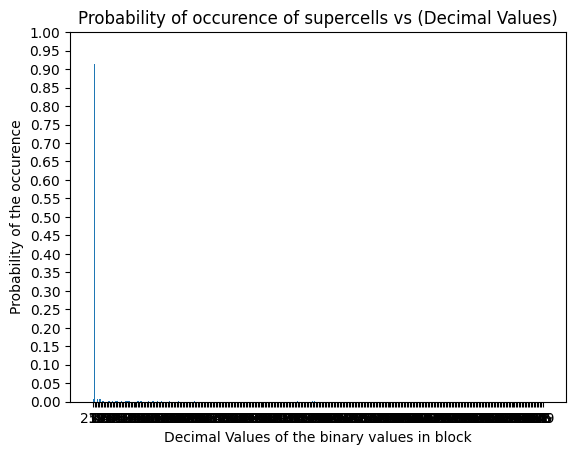

In [6]:
fhcg = FrequencyHistogramCoarseGraining(grid_array)

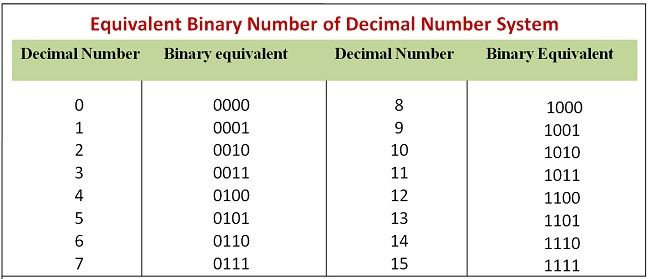

In [7]:
print(fhcg.shape)

(10, 66, 66)


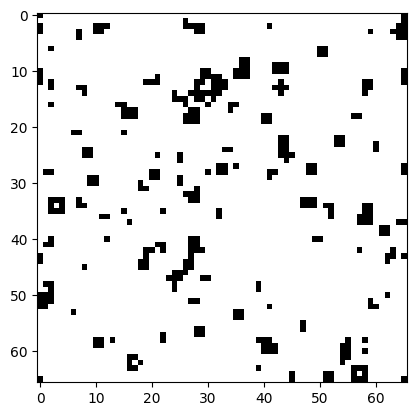

In [8]:
for i in range(len(fhcg)):
  plt.imshow(fhcg[i],cmap="binary")
  filename = "{:04d}.png".format(i)
  plt.savefig(filename)
from PIL import Image
import os

def create_gif(directory, output_filename):
    filenames = [f for f in os.listdir(directory) if f.endswith('.png')]
    filenames.sort(key=lambda x: int(x[:-4]))
    with Image.open(os.path.join(directory, filenames[0])) as im:
        sequence = [Image.open(os.path.join(directory, f)) for f in filenames]

        sequence[0].save(output_filename,
                         save_all=True,
                         append_images=sequence[1:],
                         duration=100,      # Duration of each frame (in ms)
                         loop=0)            # Number of loops (0 means infinite)


create_gif('.', 'animation_cg.gif')


In [9]:
!rm *.png


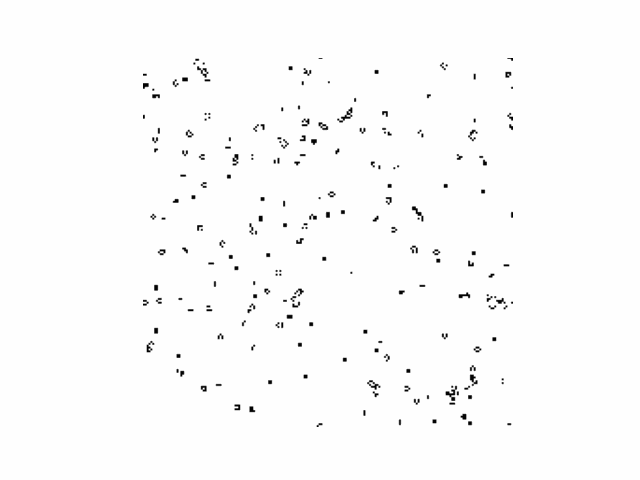
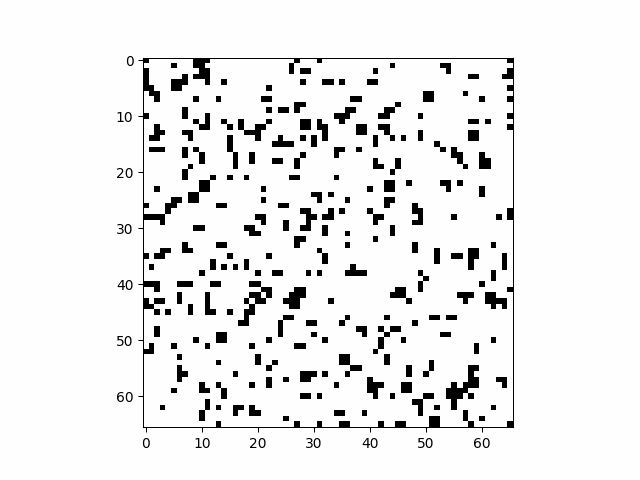

In [10]:
import base64
from IPython.display import HTML

file_path1 = 'animation_hd.gif'
file_path2 = 'animation_cg.gif'

html_code = f'''
<div style="display:flex; flex-direction:row;">
    <div style="text-align:center;">
        <img src="data:image/gif;base64,{base64.b64encode(open(file_path1,'rb').read()).decode('utf-8')}" style="width:100%; height:auto;">
        <p>{file_path1}</p>
    </div>
    <div style="text-align:center;">
        <img src="data:image/gif;base64,{base64.b64encode(open(file_path2,'rb').read()).decode('utf-8')}" style="width:100%; height:auto;">
        <p>{file_path2}</p>
    </div>
</div>
'''

HTML(html_code)
